# Deep Learning Homework \#02
### Deep Learning Course $\in$ DSSC @ UniTS (Spring 2021)  

#### Submitted by [Emanuele Ballarin](mailto:emanuele@ballarin.cc)  

### Request:

Try to reproduce in *PyTorch* the first experiment from [*Learning representations by back-propagating errors*](https://sci-hub.do/10.1038/323533a0) with learning rule from *eq. 8* (i.e. *gradient descent without momentum*).

Try to be as close as possible to the original protocol, except for what regards the learning rule, and perhaps the random initialization method.

1. Read the paper;

2. Create the data, the model and everything needed;

3. Train the model;

4. Inspect the weights you obtained and check if they provide a solution to the problem;

Compare the solution to the solution reported in the paper.

#### Imports:

We start off by importing all the libraries, modules, classes and functions we are going to use *today*...

In [1]:
# Type hints
from typing import Union, Iterable
from torch import Tensor

# Just to force-load MKL (if available)
import numpy as np

# Neural networks and friends
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# High-level abstractions over PyTorch primitives
from ebtorch.nn import FCBlock

# Model summarization
from torchinfo import summary

# Dataset handling for PyTorch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Permutation building easer
from itertools import product

# Plotting the loss function
from matplotlib import pyplot as plt


#### Dataset building & DataLoading:

We now face (and hopefully solve) the issue of building the (synthetic) dataset for the *supervised learning* problem we want to tackle.  

It is composed of:

- All (64 in total) possible 6-element lists of ${0,1}$ Boolean values; $X$
- The true target (binary) class: one among *endowed with mirror symmetry* or *not endowed with mirror symmetry*, according to -- indeed -- the property of the first half of the list (positions 1 to 3) being mirrored by the second half (positions 4 to 6); $Y$

As an example:
- The list `[0,1,1,1,0,1]` will be *not endowed with mirror symmetry*, whereas
- The list `[1,1,0,0,1,1]` will be *endowed with mirror symmetry*.

In [2]:
# Obtain the true target class (output) from any valid iterable input
def mirrsymm(iterable: Iterable) -> float:
    assert len(iterable) == 6
    # if iterable[0:3] == iterable[5:2:-1]:
    # Missing support from PyTorch side for this; what a pity!
    # What follows is the easiest non-copying version of the mirror condition :\
    if (
        iterable[0] == iterable[-1]
        and iterable[1] == iterable[-2]
        and iterable[2] == iterable[-3]
    ):
        return 1.0
    return 0.0


In [3]:
# Obtain all possible inputs (thanks, itertools!)
x: Tensor = th.tensor(
    [item for item in product([0.0, 1.0], repeat=6)], dtype=th.float32
)


In [4]:
# Obtain all corresponding outputs (thanks, crazily-flexible comprehensions!)
y: Tensor = th.tensor([[mirrsymm(myin)] for myin in x])


In [5]:
# Define training data[set | loader]
train = TensorDataset(x, y)
train_loader = DataLoader(
    train, batch_size=64, shuffle=True
)  # We do full-dataset GD, not a gain in shuffling (unless we experiment with different batch sizes!)


In [6]:
# Define testing data[set | loader]; useful (in this case) if experimenting with multiple batch sizes
train = TensorDataset(x, y)
train_loader = DataLoader(
    train, batch_size=64, shuffle=False
)  # We do full-dataset GD, not a gain in shuffling


#### Defining the model:

Now we need to build our model.  

What the original paper shows is (in a nowadays unusual canon) a *fully-connected feedforward block* with input size of $6$, output size of $1$ and one set of $2$ hidden units, connected via two hidden layers (we adopt here the definition of *layer* as an *affine operator*) of sizes, respectively, $6$-to-$2$ and $2$-to-$1$.  

As written in the experiment description, we will always use *neurons* with bias and the *Sigmoid* activation (both as hidden and output activation function).  

Particular care must be taken in order to initialize network weights as described in the original paper. However, thanks to PyTorch, such care often reduces to some looping and one pre-made function call.

In [7]:
# The model, defined using ebtorch's FC API ;)
model = FCBlock(
    fin=6,
    hsizes=[2],
    fout=1,
    hactiv=th.sigmoid,
    # hactiv=F.hardsigmoid,
    # hactiv=F.hardtanh,
    oactiv=th.sigmoid,
    # oactiv=F.hardsigmoid,
    # oactiv=lambda x: th.round(th.sigmoid(x)),
    bias=True,
)


In [8]:
# The "standard" alternative
class myMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Layers:
        self.layer1 = nn.Linear(in_features=6, out_features=2, bias=True)
        self.layer2 = nn.Linear(in_features=2, out_features=1, bias=True)
        # Stateful functions:
        # Since ReLU and SoftMax are stateless, no cruft here!

    def forward(self, x):
        x = self.layer1(x)
        x = th.sigmoid(x)
        x = self.layer2(x)
        x = th.sigmoid(x)
        return x


# model_std = myMLP()


In [9]:
# "It's better to look once more at a model that you expect rather
# than risking to use one you don't"
#                                      (Yaroslav Bulatov *)
# * the guy behind "ImageNet in 18 minutes"
summary(model)
# summary(model_std)


Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       14
|    └─Linear: 2-2                       3
Total params: 17
Trainable params: 17
Non-trainable params: 0

In [10]:
# Initialize model weights
extr = 0.3
for param in model.parameters():
    # "random and uniformly distributed between -0.3 and 0.3"
    nn.init.uniform_(param, a=-extr, b=extr)


#### Training *loop* and *mechanics*:

The following section os devoted to the training of the model, and the *put-into-place* of anything needed to actually perform the training and continuously monitor its loss.  

Since the *training set* just exhausts all possible inputs for the model, *testing-on-train* is the only available option for loss monitoring.

In [11]:
# Instantiate the optimizer (hyperparameters from the paper; but no momentum!)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.0)


In [12]:
# Instantiate the loss criterion
criterion = F.mse_loss


In [13]:
# Keep track of the loss/accuracy on a per-epoch basis
losses = []
accuracies = []


In [14]:
# Actual training loop

model.train()  # Not strictly needed *here*, but a good practice!

for epoch in range(1425):
    for x, y in train_loader:

        # Per-batch mechanics
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        losses.append(
            loss.item()
        )  # We just want the number, not the whole computational graph attached!

        # Compute accuracy on-the-fly (since batch == dataset)
        with th.no_grad():
            out = th.round(model(x))
            accuracies.append((out.eq(y.view_as(out))).sum().item() / 64.0)

        # Business as usual...
        loss.backward()
        optimizer.step()

model.eval()  # Not strictly needed *here*, but a good practice!


FCBlock(
  (linears): ModuleList(
    (0): Linear(in_features=6, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=1, bias=True)
  )
)

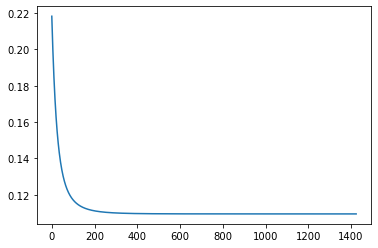

In [15]:
plt.plot(losses)


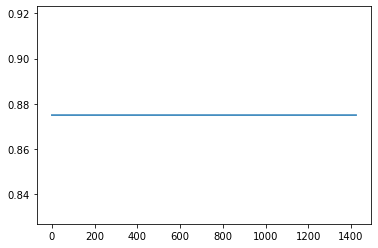

In [16]:
plt.plot(accuracies)


In [17]:
with th.no_grad():
    for param in model.parameters():
        print(param.detach().clone())


tensor([[ 0.1645,  0.2446,  0.0539, -0.1483, -0.0861,  0.2461],
        [-0.1556,  0.2733,  0.0976, -0.1093, -0.0681, -0.1610]])
tensor([0.1746, 0.1764])
tensor([[-0.5142, -0.7898]])
tensor([-1.2198])


In [18]:
print(losses[-1])
print(accuracies[-1])


0.10941808670759201
0.875


In [19]:
with th.no_grad():
    for mirrorlist in [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1],
    ]:
        print(
            th.round_(
                model(th.tensor(mirrorlist, dtype=th.float32)).detach().clone()
            ).item(),
            mirrsymm(mirrorlist),
            "\n",
        )


0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

